### Well-logs data from Utah Forge Project    https://gdr.openei.org/submissions/1111

### Regression to predict Thermal Conductivity from ONLY GR

##### Some functions adapted from https://sainosmichelle.github.io/elements.html & https://github.com/Rocks-n-Code/PythonCourse

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go
import seaborn as sns
%matplotlib inline
import sklearn
import warnings
warnings.filterwarnings('ignore')

In [52]:
#read csv saved in DataInspection_UtahForge_58 notebook
all_logs = (pd.read_csv('./localUTAHFORGEDATA/all_logs.csv')).set_index('DEPT')
#all_logs.info()

In [53]:
#read discrete data - conversion to ft - depth equal to lower depth interval 
tops = pd.read_csv('s3://geotermaldata/S3UTAHFORGEDATA/58-32_tops.csv')

#Thermal Conductivity 
TC_coredata = pd.read_csv ('s3://geotermaldata/S3UTAHFORGEDATA/58-32_thermal_conductivity_data.csv') 
TC_coredata['Depth'] = (3.28084*TC_coredata['Lower Depth Interval (m)'])
TC_coredata['Matrix_TC']=TC_coredata['matrix thermal conductivity (W/m deg C)']
TC_coredata.set_index('Depth', inplace=True)

#XRD lab data
XRD_coredata = pd.read_csv ('s3://geotermaldata/S3UTAHFORGEDATA/58-32_xray_diffraction_data.csv') 
XRD_coredata = XRD_coredata.replace('tr',0)
XRD_coredata['Depth'] = (3.28084*XRD_coredata['Lower Depth Range (m)'])
XRD_coredata.set_index('Depth', inplace=True)

#XRD_coredata.tail()

In [54]:
#Interpolation TC measurement to wireline logs scale
core = pd.concat([TC_coredata, XRD_coredata], axis=1, sort=False)
#core.head(5)
all_logs = pd.merge(all_logs, core, how = 'outer', left_index = True, right_index = True)
all_logs['Matrix_TC_int'] = all_logs['Matrix_TC'].interpolate(method = 'linear').dropna()
all_logs['logAT90']=np.log10(all_logs['AT90'])
all_logs['TEMP_ratio']=all_logs['CTEM']/all_logs['Matrix_TC_int']
all_logs.head(5)

,AF10,AF20,AF30,AF60,AF90,AO10,AO20,AO30,AO60,AO90,...,Quartz,Epidote,Calcite,Dolomite,Siderite,Anhydrite,Hematite,Matrix_TC_int,logAT90,TEMP_ratio
10.5,1.104,0.4224,20.9881,1950.0,44.9381,1.1341,0.5586,2.1295,1.7824,2.5706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.295279,NaN
11.0,1.104,0.4224,20.9881,1950.0,44.9381,1.1341,0.5586,2.1295,1.7824,2.5706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.295279,NaN
11.5,1.104,0.4224,20.9881,1950.0,44.9381,1.1341,0.5586,2.1295,1.7824,2.5706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.295279,NaN
12.0,1.104,0.4224,20.9881,1950.0,44.9381,1.1341,0.5586,2.1295,1.7824,2.5706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.295279,NaN
12.5,1.104,0.4224,20.9881,1950.0,44.9381,1.1341,0.5586,2.1295,1.7824,2.5706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.295279,NaN


In [55]:
print(all_logs.columns)

Index(['AF10', 'AF20', 'AF30', 'AF60', 'AF90', 'AO10', 'AO20', 'AO30', 'AO60',
       'AO90',
       ...
       'Quartz', 'Epidote', 'Calcite', 'Dolomite', 'Siderite', 'Anhydrite',
       'Hematite', 'Matrix_TC_int', 'logAT90', 'TEMP_ratio'],
      dtype='object', length=107)


In [56]:
logs4_reg=all_logs[['GR','CTEM','Matrix_TC_int']].dropna()
# negative values = 0
#logs4_reg['RHOZ'][logs4_reg['RHOZ'] <0] = 0
#logs4_reg['PEFZ'][logs4_reg['PEFZ'] <0] = 0

In [57]:
fig=go.Figure()
fig.layout.template = "ggplot2"
fig.add_scatter(x=logs4_reg.index, y=logs4_reg['GR'], mode='lines',name='GR')
fig.add_scatter(x=logs4_reg.index, y=logs4_reg['CTEM'], mode='lines',name='CTEM')

fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
pio.show(fig)

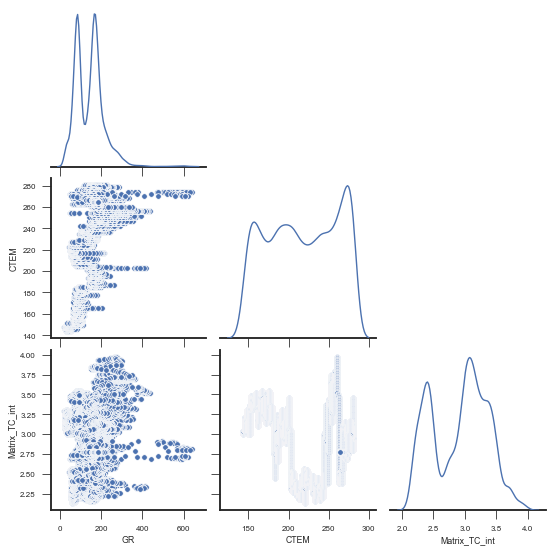

In [58]:
sns.set(style="ticks", context="talk")
plt.style.use('seaborn-paper')
#g = sns.PairGrid(logs4_reg.iloc[:,1:], diag_sharey=False, corner=True)
g = sns.PairGrid(logs4_reg, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.add_legend()

In [59]:
logs4_reg.head()

,GR,CTEM,Matrix_TC_int
100.5,33.0520,143.8118,3.000896
101.0,33.5660,143.8118,3.001791
101.5,33.1662,143.8118,3.002687
102.0,34.7645,143.8118,3.003582
102.5,37.5619,143.8118,3.004478


In [60]:
from sklearn.preprocessing import StandardScaler
cols = logs4_reg.columns
sc = StandardScaler()
X = pd.DataFrame(columns=cols[:-1], data=sc.fit_transform(logs4_reg.drop(cols[-1],axis=1)))
X.head()

,GR,CTEM
0,-1.616200,-1.728781
1,-1.608714,-1.728781
2,-1.614537,-1.728781
3,-1.591256,-1.728781
4,-1.550510,-1.728781


In [61]:
y = logs4_reg.iloc[:, -1].values

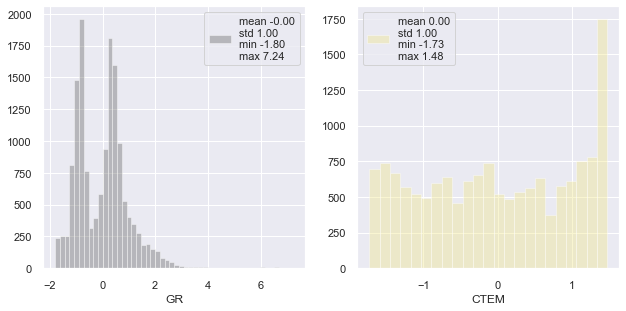

In [62]:
color = ['dimgray', 'khaki', 'mediumorchid','cornflowerblue', 'crimson','orangered', 
         'navy', 'salmon', 'Coral','SteelBlue']
sns.set(font_scale=1)
cols = X.columns
n_row = len(cols)
n_col = 2
n_sub = 1
fig = plt.figure(figsize=(5,5))
for i in range(len(cols)):
    plt.subplots_adjust(left=-0.3, right=1.3, bottom=-0.3, top=1.3)
    plt.subplot(n_row, n_col, n_sub)
    sns.distplot(X[cols[i]],norm_hist=False,kde=False, color=color[i],
                 label=['mean '+str('{:.2f}'.format(X.iloc[:,i].mean()))
                        +'\n''std '+str('{:.2f}'.format(X.iloc[:,i].std()))
                        +'\n''min '+str('{:.2f}'.format(X.iloc[:,i].min()))
                        +'\n''max '+str('{:.2f}'.format(X.iloc[:,i].max()))])                                                        
    n_sub+=1
    plt.legend()
plt.show()

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print(f'Training set size {X_train.shape}')
print(f'Testing set size {X_test.shape}')

Training set size (10463, 2)
Testing set size (4485, 2)


In [64]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [65]:
print('Linear Regression score: ', regressor.score(X_train, y_train))

Linear Regression score:  0.18906968143994551


In [66]:
from xgboost import XGBRegressor #Extreme Gradient Boosting Regressor 
xgbregressor = XGBRegressor()
xgbregressor.fit(X_train,y_train)

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
print('Training score XGBRegressor: ', xgbregressor.score(X_train,y_train) )

In [ ]:
y_pred = xgbregressor.predict(X_test)
print('Testing score XGBRegressor: ', xgbregressor.score(X_test, y_test) )

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

print ('Mean Absolute Error (MAE): ',mean_absolute_error(y_test, y_pred))
print ('R2, coeficient: ',r2_score(y_test, y_pred))

In [ ]:
predicted = y_pred
expected = y_test

df_exp_pred = pd.DataFrame()
df_exp_pred['Expected'] = pd.Series(expected)
df_exp_pred['Predicted'] = pd.Series(predicted)

figure = plt.figure(figsize=(9, 9))
axes = plt.scatter(data=df_exp_pred, x='Expected', y='Predicted', color='crimson')
plt.title('Expected vs Predicted')
plt.xlabel('Expected')
plt.ylabel('Predicted')
start = min(expected.min(), predicted.min())
end = max(expected.max(), predicted.max())
plt.xlim(start, end)
plt.ylim(start, end)
line = plt.plot([start, end], [start, end], 'k--')

In [ ]:
y_pred_all = xgbregressor.predict(X)

In [ ]:
logs4_reg['TC_predicted']= y_pred_all
logs4_reg.head()

In [ ]:
#basic plot to inspect data MODIFY TO SHOW THERMOFACIES
def make_layout_regression (log_df, XRD, TC):
    
    import numpy as np
    import pandas as pd
    import matplotlib
    import matplotlib.pyplot as plt
  
    #clusterml=np.repeat(np.expand_dims(log_df['THERMOFACIES'].values,1), 100, 1)
    ztop=log_df.index.min(); zbot=log_df.index.max()
    
    fig, axs = plt.subplots(nrows=1, ncols=7, sharey=True, squeeze=True, figsize=(15, 15), gridspec_kw={'wspace': 0.25})
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.975, top=0.7, wspace=0.2, hspace=0.2)
    axs[0].set_ylabel('Depth (ft)')
    axs[0].invert_yaxis()
    axs[0].get_xaxis().set_visible(False)
    
    # First track GR/SP/CALI logs to display
    ax1 = axs[0].twiny()  
    ax1.plot(log_df.GR, log_df.index, '-', color='#2ea869', linewidth=0.5)
    ax1.set_xlim(0,450) 
    ax1.set_xlabel('GR (API)', color='#2ea869')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.075)) 
    
    ax2 = axs[0].twiny() 
    ax2.plot(log_df.SP, log_df.index, '-', color='#0a0a0a', linewidth=0.7)
    ax2.set_xlim(-200,200) 
    ax2.set_xlabel('SP(mV)', color='#0a0a0a')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.0))    
      
    
    # Second track RHOB/NPHI/PEF logs to display
    ax1 = axs[1].twiny()  
    ax1.plot(log_df.RHOZ, log_df.index, '-', color='#ea0606', linewidth=0.5)
    ax1.set_xlim(1.5,3.0) 
    ax1.set_xlabel('RHOB (g/cm3)', color='#ea0606')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15))

    ax2 = axs[1].twiny()  
    ax2.plot(log_df.NPHI, log_df.index, '-', color='#1577e0', linewidth=0.5)
    ax2.set_xlim(1,0) 
    ax2.set_xlabel('NPHI (v/v)', color='#1577e0')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))
    
    ax3 = axs[1].twiny()  
    ax3.plot(log_df.PEFZ, log_df.index, '-', color='#1acb20', linewidth=0.5)
    ax3.set_xlim(0,15) 
    ax3.set_xlabel('PEFZ (b/e)', color='#1acb20')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[1].get_xaxis().set_visible(False)
    
    # Third track Resistivities
    ax1 = axs[2].twiny()  
    ax1.plot(log_df.logAT90, log_df.index, '-', color='#ea0606', linewidth=0.5)
    ax1.set_xlim(-1,5)  
    ax1.set_xlabel('logAT90 (ohm.m)', color='#ea0606')
    #ax1.set_xscale('log')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.0))
    ax1.grid(True)
    axs[2].get_xaxis().set_visible(False)

   # Forth track Sonic
    
    ax2 = axs[3].twiny()  
    ax2.plot(log_df.DTCO, log_df.index, '-', color='#0a0a0a', linewidth=0.5)
    ax2.set_xlim(200,40) 
    ax2.set_xlabel('DTC (us/ft)', color='#0a0a0a')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))
    
    ax3 = axs[3].twiny()  
    ax3.plot(log_df.VpVs, log_df.index, '-', color='#e1093f', linewidth=0.5)
    ax3.set_xlim(1,3) 
    ax3.set_xlabel('VpVs (unitless)', color='#e1093f')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[3].get_xaxis().set_visible(False)


  # Fifth track XRD to display
    ax1 = axs[4].twiny()  
    ax1.plot(XRD.Quartz, XRD.index, 'o', color='#eac406')
    ax1.set_xlim(0,100) 
    ax1.set_xlabel('Quartz %', color='#eac406')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15))

    ax2 = axs[4].twiny()  
    ax2.plot(XRD['K-feldspar'], XRD.index, 'o', color='#05a9f0')
    ax2.set_xlim(0,100) 
    ax2.set_xlabel('K-feldspar %', color='#05a9f0')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))
    
    ax3 = axs[4].twiny()  
    ax3.plot(XRD['Illite'], XRD.index, 'o', color='#94898c')
    ax3.set_xlim(0,100) 
    ax3.set_xlabel('Illite %', color='#94898c')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[4].get_xaxis().set_visible(False)


    # Sixth track Temp/TC to display
    ax1 = axs[5].twiny()  
    ax1.plot(TC.Matrix_TC, TC.index, 'o', color='#6e787c')
    ax1.set_xlim(0,5) 
    ax1.set_xlabel('Matrix TC Measured W/mC', color='#6e787c')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15))

    ax2 = axs[5].twiny()  
    ax2.plot(log_df.CTEM, log_df.index, '-', color='#ed8712')
    ax2.set_xlim(0,300) 
    ax2.set_xlabel('Temp degF', color='#ed8712')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))
    
    ax3 = axs[5].twiny()
    ax3.plot(log_df.TEMP_ratio, log_df.index, '-', color='#eb6105')
    #ax3.set_xlim(log_df.TEMP_ratio.min,log_df.TEMP_ratio.max)
    ax3.set_xlabel('Temp ratio', color='#eb6105')
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[5].get_xaxis().set_visible(False)
    
    # Seventh track TC Measured vs Predicted  
    ax1 = axs[6].twiny()  
    ax1.plot(log_df.Matrix_TC_int, log_df.index, 'o', color='#6e787c')
    ax1.set_xlim(0,5) 
    ax1.set_xlabel('Matrix TC Expected W/mC', color='#6e787c')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.075))

    ax2 = axs[6].twiny()  
    ax2.plot(log_df.TC_predicted, log_df.index, '-', color='#ed8712')
    ax2.set_xlim(0,5) 
    ax2.set_xlabel('Matrix TC Predicted W/mC', color='#ed8712')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.0))
    axs[6].get_xaxis().set_visible(False)
         
    fig.suptitle('Lineal Regression for Thermal Conductivity well 58-32',weight='bold', fontsize=20, y=0.9);
    plt.show()


In [ ]:
make_layout_regression (logs4_reg, XRD_coredata, TC_coredata)